# Classifying CIFAR-10 Dataset with All Convolutional Neural Network 

This notebook aims to classify images into 10 classes: Plane, Car, Bird, Cat, Deer, Dog, Frog, Horse, Boat, and Truck. The model being used is a deep convoluational neural network with only convolutional layers, as documented in the paper: https://arxiv.org/pdf/1412.6806.pdf . Used Keras with tensorflow backend and used callback functions to save the training progresss and cross-validation accuracies during training. Learnt to use data augmentation to improve model generalization. To further boost the accuracies, I averaged results by several models trained with different hyperparameters. The highest test accuracy was ~90%. 

This is for mounting the google drive for saving.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
from tensorflow.keras.datasets import cifar10
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Data Preprocessing
Loading the dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

There are 50,000 training images and 10,000 testing images.

In [ ]:
print('Training images: {}'.format(X_train_o.shape))
print('Testing images: {}'.format(X_test_o.shape))

Training images: (50000, 32, 32, 3)
Testing images: (10000, 32, 32, 3)


From left to right and top to bottom (Classes):


0.   Plane
1.   Car
2.   Bird
3.   Cat
4.   Deer
5.   Dog
6.   Frog
7.   Horse
8.   Ship
9.   Truck

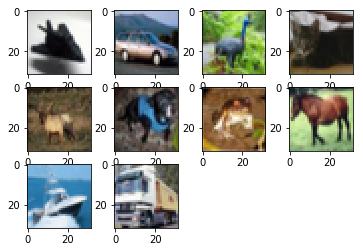

In [ ]:
# Define arrays
classes = [0,1,2,3,4,5,6,7,8,9]
class_images = [None]*10
y_train_list = list(y_train)
# Find the class images
for c in classes:
  i = y_train_list.index(c)
  class_images[c] = X_train[i,:,:,:]
# Display them
for i in range(0,10):
  plt.subplot(3,4,1+i)
  plt.imshow(class_images[i])

## Data preprocessing
Rescaling the dataset to the mean using the range.

In [ ]:
# images go from 255 to 0
print(X_test.max())
print(X_test.min())

255
0


In [ ]:
# normalize the images
X_train_n = X_train/255
X_test_n = X_test/255

Because y is a vector of classes from 0 to 9, we need to convert each into a vector of 10 length with 1 and 0. 

In [ ]:
# original target array
pd.DataFrame(np.array(y_train[0:5]),columns=['Target'])

,Target
0,6
1,9
2,9
3,4
4,1


In [ ]:
# Convert the 0 - 9 labels to an array of length 10 array with only 1 and 0
y_train_hot = np_utils.to_categorical(y_train)
y_test_hot = np_utils.to_categorical(y_test)

In [ ]:
# This is the matrix
pd.DataFrame(np.array(y_train_hot[0:5]))

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building a Keras model according to the All-CNN netword paper in reference 1.
The model outline can be described below:

Model-C

#### Layer 1
* 3 x 3 conv. 96 ReLU (Input 32 x 32 RGB image, dropout = 0.2)
* 3 x 3 conv. 96 ReLU
---------------
#### Replace max pooling with CNN
* 3 x 3 conv. 96 ReLU, stride r = 2, dropout = 0.5
--------------
#### Layer 2
* 3 x 3 conv. 192 ReLU
* 3 x 3 conv. 192 ReLU
--------------
#### Replace max pooling with CNN
* 3 x 3 conv. 192, stride r = 2, dropout = 0.5
--------------
#### Layer 3
* 3 x 3 conv. 192 ReLU
-------------
#### Layer 4
* 1 x 1 conv. 192 ReLU
--------------
#### Layer 5
* 1 x 1 conv. 10 ReLU
--------------
#### global averaging over 6 x 6 spatial dimensions
-------------
#### Output layer
* 10 or 100-way softmax



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD


from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras as keras


from sklearn.metrics import accuracy_score, classification_report
import numpy as np
def make_model(drop=0,reg=0.0005,lr=0.01,decay=1E-6,momentum=0.9):
  input_shape=(32,32,3)
  model = Sequential()
  re = l2(reg)
  ### layer 1
  model.add(Conv2D(96,(3,3),padding='same',input_shape=input_shape,activation='relu',kernel_regularizer=re))
  model.add(Dropout(0.2))
  model.add(Conv2D(96,(3,3),padding='same',activation='relu',kernel_regularizer=re))
  model.add(Dropout(drop))

  ### replace max pooling with CNN
  model.add(Conv2D(96,(3,3),padding='same',strides=(2,2),activation='relu',kernel_regularizer=re))
  model.add(Dropout(0.5))

  ### layer 2
  model.add(Conv2D(192,(3,3),padding='same',activation='relu',kernel_regularizer=re))
  model.add(Conv2D(192,(3,3),padding='same',activation='relu',kernel_regularizer=re))
  model.add(Dropout(drop))
  ### replace max pooling with CNN
  model.add(Conv2D(196,(3,3),padding='same',strides=(2,2),activation='relu',kernel_regularizer=re))
  model.add(Dropout(0.5))
  ### layer 3
  model.add(Conv2D(192,(3,3),padding='same',activation='relu',kernel_regularizer=re))
  model.add(Dropout(drop))
  ### layer 4
  model.add(Conv2D(192,(1,1),padding='valid',activation='relu',kernel_regularizer=re))
  model.add(Dropout(drop))
  ### layer 5
  model.add(Conv2D(10,(1,1),padding='valid',activation='relu',kernel_regularizer=re))
  model.add(Dropout(drop))
  ### global averaing over 6 x 6 spatial dimensions
  model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))
  

  sgd = SGD(lr=lr,decay=decay,momentum=momentum,nesterov=True)
  model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  
  return model


## Training model


#### Data augmentation:
This process allows images to be shifted, zoomed, sheared, and flipping horizontally. This produces more variability in the images fed into the model. In a way, it increases the training set


#### Hyperparameters:
* learning rate = 0.01 and dividing by 10 after every 200,000 iterations
*weight decay = 0.0005
* momentum = 0.9
*epochs = 350
*batch_size = 64

#### Callbacks:
This amazing functionality in keras allows automation including:
* Saving the model periodically during the training (ModelCheckpoint)
* Saving the losses and accuracies each epoch (CSVLogger)

#### Cross Validation:
Using train test split to split the training data into training and cross validation sets. This will prevent overfitting of the testing set when trying to tune the hyperparameters

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, ShuffleSplit
# Defining the data augmentation
datagen = ImageDataGenerator(rotation_range=1,
                            width_shift_range=0.01,
                            height_shift_range=0.01,
                            zoom_range=0.01,
                            shear_range=0.01,
                            horizontal_flip=True)
# Define the path to save
path = 'gdrive/My Drive/Colab saves/Try10/'
# Define the callbacks
logger = CSVLogger(path+'log.csv',append=True)
checkpt = ModelCheckpoint(path+'model.{epoch:02d}-{val_acc:.2f}.2.h5',
                          save_best_only=True,
                          monitor='val_acc',
                          period=20)
# Saving the info for this training
f = open(path+'description.txt','w')
f.write('normal decay. reduced datagen params')
f.close()

# split the training data into training set and cross validation set
X_t,X_v,y_t,y_v = train_test_split(X_train_n,y_train_hot,random_state=1)
# call the building function
model = make_model()
# fit the model using fit_generator function. 
# datagen.flow() allows real time generation of training data
model.fit_generator(datagen.flow(X_t,y_t,batch_size=32),
                   steps_per_epoch=len(X_t)/32,epochs=350,
                   verbose=2,validation_data=(X_v,y_v),
                   callbacks=[logger,checkpt])
# save the final model
model.save(path+'final.h5')

## Model Evaluation

Loading the two best models I have gotten. Use them to predict the test set. Also tried ensemble averaging the two models' predictions. The accuracy of the model improved.

In [ ]:
# Load and predict
best_model1 = keras.models.load_model('gdrive/My Drive/Colab saves/Try4 (goog model)/model.360-0.88.h5')
best_model2 = keras.models.load_model('gdrive/My Drive/Colab saves/Try10/model.400-0.882.h5')
pred1 = best_model1.predict(X_test_n)
pred2 = best_model2.predict(X_test_n)
# Combine the probability predictions of the two models
combined_pred = (pred1+pred2)/2
# Convert the probabilities to discrete 1 and 0 predictions
pred1 = np_utils.to_categorical(np.argmax(pred1,axis=1))
pred2 = np_utils.to_categorical(np.argmax(pred2,axis=1))
combined_pred = np_utils.to_categorical(np.argmax(combined_pred,axis=1))
# scoring them
print(classification_report(pred1,y_test_hot))
print(classification_report(pred2,y_test_hot))
print(classification_report(combined_pred,y_test_hot))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1003
           1       0.96      0.93      0.94      1030
           2       0.86      0.80      0.83      1074
           3       0.71      0.80      0.75       893
           4       0.91      0.81      0.86      1124
           5       0.81      0.85      0.83       946
           6       0.88      0.94      0.91       939
           7       0.92      0.90      0.91      1027
           8       0.93      0.94      0.93       987
           9       0.91      0.93      0.92       977

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000
 samples avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1021
           1       0.95      0.93      0.94      1015
           2       0.84 

I figured I could also use the previous models I tried in the ensemble prediction to get a better performance. I turned out that **it works!**.

I have **90% accuracy!**

Looks like it still has more trouble with the classes 2 (bird), 3 (cat), and 5 (dog). 

In [ ]:
# Defining paths
paths = ['gdrive/My Drive/Colab saves/Try4 (goog model)/model.360-0.88.h5',
         'gdrive/My Drive/Colab saves/Try5/model.240-0.85.h5',
         'gdrive/My Drive/Colab saves/Try6/model.420-0.87.h5',
         'gdrive/My Drive/Colab saves/Try7/model.340-0.87.h5',
         'gdrive/My Drive/Colab saves/Try8/model.120-0.84.h5',
         'gdrive/My Drive/Colab saves/Try9/model.260-0.85.h5',
         'gdrive/My Drive/Colab saves/Try10/model.400-0.882.h5',
         'gdrive/My Drive/Colab saves/Try 1/classifier50.h5',
         'gdrive/My Drive/Colab saves/Try 1/classifier_drop56.h5',
         'gdrive/My Drive/Colab saves/Try 1/classifier9.h5',
         'gdrive/My Drive/Colab saves/Try2/classifier4.h5']
print('Reading models...')
all_models = [keras.models.load_model(p) for p in paths]
print('Done reading.')
# Average the results of the ensemble
ensemble_pred = np.zeros(y_test_hot.shape)
n = len(all_models)
for i,m in enumerate(all_models):
  print('Predicting using model ' + str(i))
  ensemble_pred += m.predict(X_test_n)/n
# convert to 1 and 0 predictions
ensemble_pred = np_utils.to_categorical(np.argmax(ensemble_pred,axis=1))
# score the accuracy
print(classification_report(ensemble_pred,y_test_hot))
print(accuracy_score(ensemble_pred,y_test_hot))

Reading models...
Done reading.
Predicting using model 0
Predicting using model 1
Predicting using model 2
Predicting using model 3
Predicting using model 4
Predicting using model 5
Predicting using model 6
Predicting using model 7
Predicting using model 8
Predicting using model 9
Predicting using model 10
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1054
           1       0.96      0.95      0.95      1014
           2       0.84      0.89      0.86       945
           3       0.79      0.81      0.80       970
           4       0.91      0.87      0.89      1039
           5       0.83      0.88      0.85       944
           6       0.94      0.92      0.93      1026
           7       0.94      0.93      0.94      1009
           8       0.94      0.94      0.94      1000
           9       0.93      0.93      0.93       999

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.9

# References:
1) https://arxiv.org/pdf/1412.6806.pdf

2) https://www.eduonix.com/learn-machine-learning-by-building-projects